In the second week of the [Data Analysis Tools](https://www.coursera.org/learn/data-analysis-tools/) course, we're using the $\chi^2$ (chi-square(d)) test to compare two categorical variables. Maybe you remember that my **Breast Cancer Causes Internet Usage!** (BCCIU) [project](http://lilithelina.tumblr.com/post/128347327089/choice-of-data) contains only numerical data - just like the whole [Gapminder](http://www.gapminder.org/) data subset we were given in the course. This means there will be some further categorising today!

As before, the output will look lots better in the [nbviewer](http://nbviewer.ipython.org/github/LilithElina/Data-Analysis-and-Interpretation/tree/master/DataAnaT/Week%20Two%20-%20Chi-Square.ipynb) than on tumblr.

First up comes some of the code I created before, to prepare the raw data.

In [1]:
# activate inline plotting, should be first statement
%matplotlib inline

# load packages
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import scipy.stats                  # for chi-square

# read in data
data = pandas.read_csv("../gapminder.csv", low_memory=False)

# subset the data and make a copy to avoid error messages later on
sub = data[["country", "breastcancerper100th", "femaleemployrate", "internetuserate"]]
sub_data = sub.copy()

# change data types to numeric (NEW CODE!)
sub_data["breastcancerper100th"] = pandas.to_numeric(sub_data["breastcancerper100th"], errors="coerce")
sub_data["femaleemployrate"] = pandas.to_numeric(sub_data["femaleemployrate"], errors="coerce")
sub_data["internetuserate"] = pandas.to_numeric(sub_data["internetuserate"], errors="coerce")

# remove rows with missing values (copy again)
sub2 = sub_data.dropna()
sub_data2 = sub2.copy()

For my last post on [ANOVA](http://lilithelina.tumblr.com/post/132593030304/data-analysis-anova-python), I already categorised my explanatory variable: new breast cancer cases in 2002. I'll keep the four groups I created then, and now additionally also categorise the female employment rates from 2007 and the internet use rates from 2010. These response variables will only be split in two ("low" and "high"), since the $\chi^2$ test results will be easier to interpret then.

breast cancer cases per 100,000 females - quartiles
25th     41
50th     40
75th     40
100th    41
dtype: int64

female employment rate - two groups
0    81
1    81
Name: employtwo, dtype: int64

internet use rate - two groups
0    81
1    81
Name: interntwo, dtype: int64


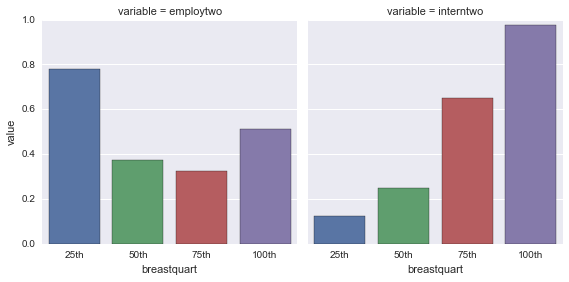

In [2]:
# quartile split (use qcut function & ask for 4 groups) for breast cancer
print("breast cancer cases per 100,000 females - quartiles")
sub_data2["breastquart"] = pandas.qcut(sub_data2.breastcancerper100th, 4,
                                       labels=["25th", "50th", "75th", "100th"])
sub_data2["breastquart"] = sub_data2.breastquart.astype("category")
print(sub_data2["breastquart"].value_counts(sort=False))

# two group split for female employment (at median)
print("\nfemale employment rate - two groups")
sub_data2["employtwo"] = pandas.qcut(sub_data2.femaleemployrate, 2, labels=[0, 1])
sub_data2["employtwo"] = pandas.to_numeric(sub_data2["employtwo"], errors="coerce")
print(sub_data2["employtwo"].value_counts(sort=False))

# two group split for internet usage (at median)
print("\ninternet use rate - two groups")
sub_data2["interntwo"] = pandas.qcut(sub_data2.internetuserate, 2, labels=[0, 1])
sub_data2["interntwo"] = pandas.to_numeric(sub_data2["interntwo"], errors="coerce")
print(sub_data2["interntwo"].value_counts(sort=False))

# "melt" the data into better (long) format for factorplot()
sub_data2.m = pandas.melt(sub_data2, id_vars=["breastquart"], value_vars=["employtwo", "interntwo"])

# plot percent in high response group over breast cancer quartiles
seaborn.factorplot(x="breastquart", y="value", col="variable", data=sub_data2.m,
                   kind="bar", ci=None, order=["25th", "50th", "75th", "100th"]);

The function `qcut()` always creates equally sized groups, which means that we get a quartile split for the breast cancer cases, and a split at the median for the two response variables. I chose to code "low" female empoyment or internet usage as $0$, and the "high" group as $1$. That way, I can visualise the percentage (from $0$ to $1$) of the "high" category cases over the breast cancer quartiles with bar charts. The result is very similar to what we've seen in the boxplot last time: a linear relationship between breast cancer and internet usage, but not with female employment.  
*Side note: While bar charts are fine to use for count or categorical data, I would never use them for my original data. I also would not recommend grouping variables like that without very good reason (in my case, this is ONLY because the course requires it). You can read a bit more about bar charts and boxplots [here](http://www.nature.com/nmeth/journal/v11/n2/full/nmeth.2807.html), or about the dangers of dynamite plots (bar charts with error bars) [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiRcode/Poster3.pdf).*

Similar to the ANOVA analysis, we can now run $\chi^2$ tests to check if the relative proportions of the response variables differ between the breast cancer categories. The null hypothesis is, of course, that this is not the case - the variables are independent of each other.  
This comparison is done by calculating the expected proportions and comparing them with the observed ones (plotted above). We can do that before we run the actual test, using the group sizes above as row and column sums, respectively: i.e. the low female employment group will always have 81 observances, just like the high group, while the breast cancer groups are always 40 or 41 observances strong. To get the expected values, we have to multiply the row and column sums and divide by the overall sum ($81+81=162$, or $41+40+40+41=162$). This means that we'll get very similar expected values for all variable pairs.

In [3]:
# create DataFrame with expected values
print("expected values in the breast cancer quartiles")
expected = pandas.DataFrame.from_items([("25th", [(41*81)/162, (41*81)/162]),
                                        ("50th", [(40*81)/162, (40*81)/162]),
                                        ("75th", [(40*81)/162, (40*81)/162]),
                                        ("100th", [(41*81)/162, (41*81)/162])])
print(expected)

# contingency table of observed employment counts
print("\nobserved values for female employment groups")
employ_cont = pandas.crosstab(sub_data2["employtwo"], sub_data2["breastquart"])
print (employ_cont)

# contingency table of observed internet usage counts
print("\nobserved values for internet usage groups")
intern_cont = pandas.crosstab(sub_data2["interntwo"], sub_data2["breastquart"])
print (intern_cont)

expected values in the breast cancer quartiles
   25th  50th  75th  100th
0  20.5    20    20   20.5
1  20.5    20    20   20.5

observed values for female employment groups
breastquart  25th  50th  75th  100th
employtwo                           
0               9    25    27     20
1              32    15    13     21

observed values for internet usage groups
breastquart  25th  50th  75th  100th
interntwo                           
0              36    30    14      1
1               5    10    26     40


With always $81$ as row total, each row has the same expected value in each column. Additionally, since the column totals are almost equal as well, we have two pairs of identical columns each. The observed values differ greatly from that - only the fourth group of breast cancer cases shows almost expected values for the two employment categories. Expect to see some significant *p*-values in the $\chi^2$ tests!

In [4]:
# chi-squared test (takes contingency table as input)
print ("chi-squared test for female employment and breast cancer")
employ_chi = scipy.stats.chi2_contingency(employ_cont)
print (employ_chi)

print ("\n\nchi-squared test for internet usage and breast cancer")
intern_chi = scipy.stats.chi2_contingency(intern_cont)
print (intern_chi)

chi-squared test for female employment and breast cancer
(20.326829268292684, 0.00014522261921541131, 3, array([[ 20.5,  20. ,  20. ,  20.5],
       [ 20.5,  20. ,  20. ,  20.5]]))


chi-squared test for internet usage and breast cancer
(74.136585365853648, 5.548112375941971e-16, 3, array([[ 20.5,  20. ,  20. ,  20.5],
       [ 20.5,  20. ,  20. ,  20.5]]))


The `chi2_contingency()` function doesn't offer a nicely formatted output. The values, in order of appearance, are: the $\chi^2$ value, *p*-value, degrees of freedom, array of expected values. If we were doing the test by hand (yes, [that is possible](https://en.wikipedia.org/wiki/Chi-squared_test#Example_chi-squared_test_for_categorical_data)), we would only get the $\chi^2$ value, and would then have to determine the degrees of freedom (number of rows minus one times number of columns minus one: $(2-1)*(4-1)=3$ in this case). Using both these values, we could look up the *p*-value in a reference table.  
This is not necessary here - Python already shows us that we can reject the null hypothesis in both cases. Similar to ANOVA, though, we can't be certain *which* of the breast cancer categories are not independent of female employment or internet usage. To figure that out, we have to run the same test on all pairwise comparisons (25th versus 50th and so on). In the course, they had 15 comparisons to do, and they did them by hand. Luckily, I've been programming in Python for some time now - I'll use nested `for` loops instead.

In [5]:
# extract breast cancer categories
cats = list(set(sub_data2["breastquart"]))

print("breast cancer versus female employment")
for x in range(0, len(cats)-1):      # use all categories except last
    for y in range(x+1, len(cats)):  # use all categories starting one up from the one that's currently x
        recode = {cats[x]: cats[x], cats[y]: cats[y]}
        sub_data2["comp"] = sub_data2["breastquart"].map(recode)
        cont = pandas.crosstab(sub_data2["employtwo"], sub_data2["comp"])
        chi = scipy.stats.chi2_contingency(cont)
        print("\n", cats[x], " versus ", cats[y],
              "\nChi value: ", chi[0], "\tp value: ", chi[1])

print("\n\nbreast cancer versus internet usage")
for x in range(0, len(cats)-1):      # use all categories except last
    for y in range(x+1, len(cats)):  # use all categories starting one up from the one that's currently x
        recode = {cats[x]: cats[x], cats[y]: cats[y]}
        sub_data2["comp"] = sub_data2["breastquart"].map(recode)
        cont = pandas.crosstab(sub_data2["interntwo"], sub_data2["comp"])
        chi = scipy.stats.chi2_contingency(cont)
        print("\n", cats[x], " versus ", cats[y],
              "\nChi value: ", chi[0], "\tp value: ", chi[1])

breast cancer versus female employment

 50th  versus  100th 
Chi value:  1.0378125 	p value:  0.308330772811

 50th  versus  75th 
Chi value:  0.0549450549451 	p value:  0.814671652089

 50th  versus  25th 
Chi value:  12.0539471023 	p value:  0.000516828310117

 100th  versus  75th 
Chi value:  2.19512280976 	p value:  0.13844817418

 100th  versus  25th 
Chi value:  5.3350683149 	p value:  0.0209005209674

 75th  versus  25th 
Chi value:  15.2177515244 	p value:  9.57986606414e-05


breast cancer versus internet usage

 50th  versus  100th 
Chi value:  42.1043942762 	p value:  8.6528534509e-11

 50th  versus  75th 
Chi value:  11.3636363636 	p value:  0.000748960447639

 50th  versus  25th 
Chi value:  1.43332732816 	p value:  0.231222183466

 100th  versus  75th 
Chi value:  12.1501122506 	p value:  0.000490849101591

 100th  versus  25th 
Chi value:  56.9321321321 	p value:  4.51114447892e-14

 75th  versus  25th 
Chi value:  21.7141897128 	p value:  3.16441930002e-06


To shorten the output a bit, I only printed the $\chi^2$ value and the *p*-value for each breast cancer category pair.  
And now, maybe you remember from the ANOVA script, we have again a [multiple comparison problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)! Therefore, we can't take the *p*-values as they are. In one test, $p < 0.05$ might mean that there's only a 5% chance of mistakenly rejecting the null hypothesis, but we are overall doing 12 tests, which increases the likelihood of a rare event occuring by chance. In the course, we were introduced to the (quite conservative) Bonferroni correction, which maintains the family wise error rate (FWER, [see ANOVA post](http://lilithelina.tumblr.com/post/132593030304/data-analysis-anova-python)). This is done simply by dividing the *p*-value we would like to use as threshold ($0.05$) by the number of tests we're doing: $0.05/12 = 0.0042$.

Using this as our significance threshold, we can only reject the null hypothesis in the following cases.  
For female employment, we could see a general significant association ($\chi^2 = 20.33$, $3$ degrees of freedom, $p = 0.000145$) with breast cancer. The post hoc tests revealed, though, that only the 25th breast cancer quartile differs significantly from the 50th and 75th quartiles. Unlike with ANOVA, there is no significance in the comparison of the 25th and 100th quartile. We can also see in the barplot that high female employment mostly occurs in these first and last groups, so that fits with the conclusion that female employment is higher in countries with low breast cancer occurance (9 countries with "low" female employment, 32 with "high" in the 25th breast cancer quartile).  
Internet usage and breast cancer are also significantly associated ($\chi^2 = 74.14$, $3$ degrees of freedom, $p = 5.5481e-16$). Here, the results are the same as before: all breast cancer groups differ significantly, except the first two (25th and 50th quartile): countries with more breast cancer cases also show higher internet use rates.